In [5]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff


In [6]:

nltk.download('stopwords')
nltk.download('punkt')

primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_grey = "#c6ccd8"

df = pd.read_csv("fake_or_real_news.csv")

df['message'] = df['title'] + ' ' + df['text']
df = df[['label', 'message']]
df.columns = ['target', 'message']



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:

balance_counts = df.groupby('target')['target'].agg('count').values
fig = go.Figure()
fig.add_trace(go.Bar(x=['FAKE'], y=[balance_counts[0]], name='FAKE', text=[balance_counts[0]], textposition='auto', marker_color=primary_blue))
fig.add_trace(go.Bar(x=['REAL'], y=[balance_counts[1]], name='REAL', text=[balance_counts[1]], textposition='auto', marker_color=primary_grey))
fig.update_layout(title={'text': '<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>', 'x': 0.5, 'xanchor': 'center'})
fig.show()

fake_df = df[df['target'] == 'FAKE']['message'].str.len().value_counts().sort_index()
real_df = df[df['target'] == 'REAL']['message'].str.len().value_counts().sort_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=fake_df.index, y=fake_df.values, name='FAKE', fill='tozeroy', marker_color=primary_blue))
fig.add_trace(go.Scatter(x=real_df.index, y=real_df.values, name='REAL', fill='tozeroy', marker_color=primary_grey))
fig.update_layout(title='<span style="font-size:32px; font-family:Times New Roman">Message Length Distribution</span>')
fig.update_xaxes(range=[0, 1000])
fig.show()


In [8]:

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['message_clean'] = df['message'].apply(clean_text)
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
stemmer = SnowballStemmer("english")
def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text
df['message_clean'] = df['message_clean'].apply(stemm_text)

def preprocess_data(text):
    text = clean_text(text)
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text
df['message_clean'] = df['message_clean'].apply(preprocess_data)

le = LabelEncoder()
le.fit(df['target'])
df['target_encoded'] = le.transform(df['target'])



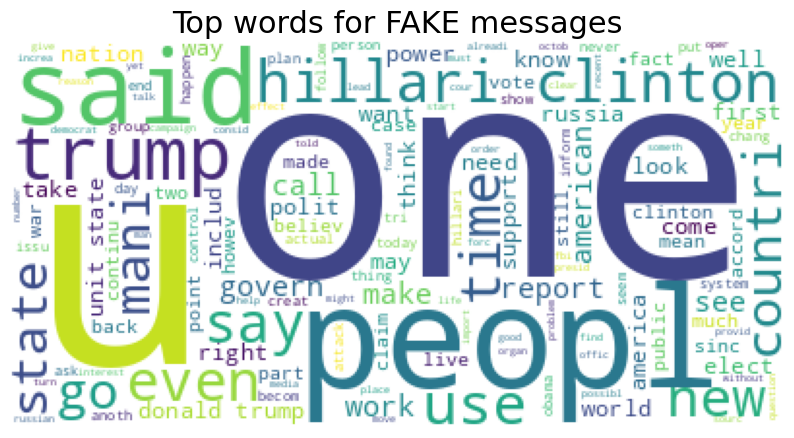

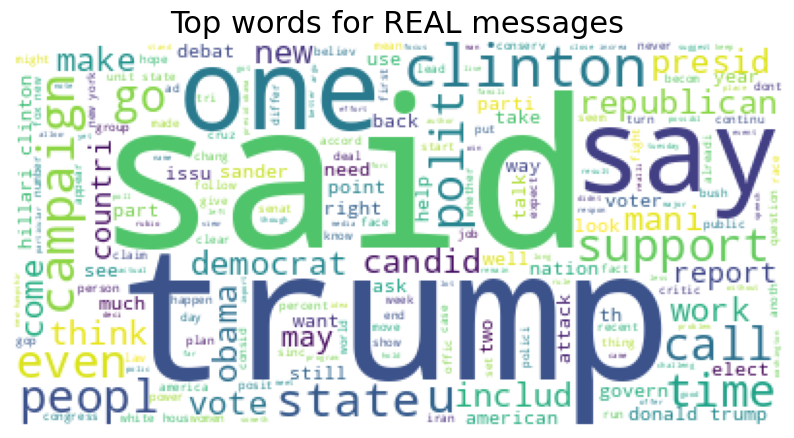

In [9]:
wc = WordCloud(background_color='white', max_words=200)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'FAKE', 'message_clean']))
plt.figure(figsize=(10,7))
plt.title('Top words for FAKE messages', fontdict={'size': 22})
plt.imshow(wc)
plt.axis("off")
plt.show()

wc = WordCloud(background_color='white', max_words=200)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'REAL', 'message_clean']))
plt.figure(figsize=(10,7))
plt.title('Top words for REAL messages', fontdict={'size': 22})
plt.imshow(wc)
plt.axis("off")
plt.show()


In [10]:

x = df['message_clean']
y = df['target_encoded']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)
vocab_length = len(word_tokenizer.word_index) + 1
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)
length_long_sentence = 100
train_padded_sentences = pad_sequences(embed(x_train), length_long_sentence, padding='post')
test_padded_sentences = pad_sequences(embed(x_test), length_long_sentence, padding='post')

embeddings_dictionary = {}
embedding_dim = 100
with open("/content/glove.6B.100d.txt", encoding="utf8") as fp:
    for line in fp:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector



In [11]:
def glove_lstm():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences=True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = glove_lstm()
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5, min_lr=0.001)
history = model.fit(train_padded_sentences, y_train, epochs=10, batch_size=32, validation_data=(test_padded_sentences, y_test), verbose=1, callbacks=[reduce_lr, checkpoint])


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6463 - loss: 0.7579
Epoch 1: val_loss improved from inf to 0.59638, saving model to model.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 64s 363ms/step - accuracy: 0.6466 - loss: 0.7574 - val_accuracy: 0.7514 - val_loss: 0.5964 - learning_rate: 0.0010
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7513 - loss: 0.5468
Epoch 2: val_loss improved from 0.59638 to 0.46797, saving model to model.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 79s 342ms/step - accuracy: 0.7514 - loss: 0.5467 - val_accuracy: 0.8193 - val_loss: 0.4680 - learning_rate: 0.0010
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7807 - loss: 0.4833
Epoch 3: val_loss improved from 0.46797 to 0.36418, saving model to model.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 82s 345ms/step - accuracy: 0.7807 - loss: 0.4831 - val_accuracy: 0.8382 - val_loss: 0.3642 - learning_rate: 0.0010
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8232 - loss: 0.3994
Epoch 4: val_loss did not improve from 0.36418
159/159 ━━━━━━━━━━━━━━━━━━━━ 82s 345ms/step - accuracy: 0.8232 - loss: 0.3994 - val_accuracy: 0.8232 - val_loss: 0.4025 - learning_rate: 0.0010
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8570 - loss: 0.3566
Epoch 5: val_loss improved from 0.36418 to 0.32465, saving model to model.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 81s 343ms/step - accuracy: 0.8570 - loss: 0.3566 - val_accuracy: 0.8540 - val_loss: 0.3247 - learning_rate: 0.0010
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8596 - loss: 0.3213
Epoch 6: val_loss improved from 0.32465 to 0.30114, saving model to model.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 55s 344ms/step - accuracy: 0.8596 - loss: 0.3214 - val_accuracy: 0.8587 - val_loss: 0.3011 - learning_rate: 0.0010
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8769 - loss: 0.2926
Epoch 7: val_loss did not improve from 0.30114
159/159 ━━━━━━━━━━━━━━━━━━━━ 84s 359ms/step - accuracy: 0.8769 - loss: 0.2926 - val_accuracy: 0.8287 - val_loss: 0.4014 - learning_rate: 0.0010
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8947 - loss: 0.2579
Epoch 8: val_loss did not improve from 0.30114
159/159 ━━━━━━━━━━━━━━━━━━━━ 57s 359ms/step - accuracy: 0.8947 - loss: 0.2579 - val_accuracy: 0.8611 - val_loss: 0.3282 - learning_rate: 0.0010
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9057 - loss: 0.2290
Epoch 9: val_loss did not improve from 0.30114
159/159 ━━━━━━━━━━━━━━━━━━━━ 79s 344ms/step - accuracy: 0.9057 - loss: 0.2291 - val_accuracy: 0.8445 - val_loss: 0.3632 - learning_rate: 0.0010
Epoch 10/10
159/159

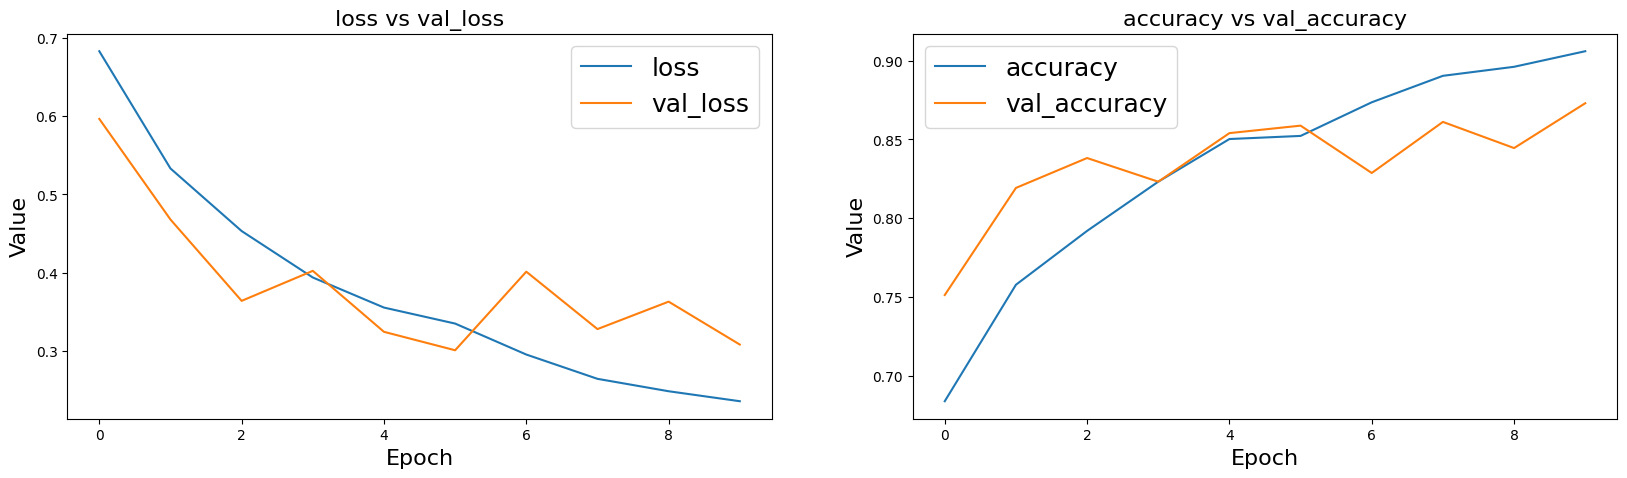

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step


In [12]:

def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('Epoch',fontsize=16)
        ax[idx].set_ylabel('Value',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' vs ' + arr[idx][1],fontsize=16)
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])
plt.show()

y_preds = (model.predict(test_padded_sentences) > 0.5).astype("int32")
conf_matrix_data = confusion_matrix(y_test, y_preds)
categories = ['FAKE','REAL']
fig = ff.create_annotated_heatmap(conf_matrix_data, x=categories, y=categories, colorscale='Viridis', showscale=True)
fig.update_layout(title_text='Confusion matrix', xaxis = dict(title='Predicted value'), yaxis = dict(title='Real value'))
fig.show()